In [2]:
options(stringsAsFactors = FALSE, repr.plot.width=16, repr.plot.height=9)
library(dplyr)
library(ggplot2)
library(tidyr)
library(caret)
library(cowplot)
library(pheatmap)

set.seed(20220327)

## predict the best matrix/polarity for a given molecule based on their molecular fingerprint

by Martijn Molenaar, m.r.molenaar@protonmail.com

In [21]:
## read in data 
spotting_data <- read.csv(file = '3june22_ions_no_nl_secondary_adducts.csv')

fingerprints <- read.csv(file = 'fingerprints.csv')

physchem_properties <- read.csv(file = 'physchem_properties.csv')

In [22]:
colnames(fingerprints) <- gsub("^X","bit#",colnames(fingerprints))

In [23]:
physchem_properties$pka_strongest_acidic[is.na(
     physchem_properties$pka_strongest_acidic)] <- max(physchem_properties$pka_strongest_acidic, na.rm = T)


physchem_properties$pka_strongest_basic[is.na(
     physchem_properties$pka_strongest_basic)] <- min(physchem_properties$pka_strongest_basic, na.rm = T)

In [24]:
physchem_properties[,-1] <- sapply(physchem_properties[,-1], scale)
fingerprints[,-1] <- sapply(fingerprints[,-1], scale)

In [25]:
fingerprints <-  left_join(x = fingerprints  %>% rename(name_short = mol_name),
            y = physchem_properties,  by = 'name_short')

In [26]:
bit_columns <- grep("bit",colnames(fingerprints))
phys_columns <- which(colnames(fingerprints) %in% colnames(physchem_properties[,-1]))


In [27]:
colnames(spotting_data)[colnames(spotting_data) == 'Matrix.short'] <- 'matrix'
colnames(spotting_data)[colnames(spotting_data) == 'Polarity'] <- 'polarity'


In [37]:
## summarise spotting data 
## spot_sum_intensity_relative is relative performance of a molecule between the matrices.
## 0 = worst, 1 = best

spotting_data_summary <-
spotting_data %>% group_by(matrix, polarity, name_short) %>%
  summarise(spot_sum_intensity = max(spot_intensity),
            spot_sum_intensity = ifelse(spot_sum_intensity < 0,0,spot_sum_intensity),
            spot_sum_intensity = sqrt(spot_sum_intensity)   ## arbitrary transformation
            ) %>%
  ungroup() %>% 
  group_by(name_short) %>%
  mutate(spot_sum_intensity_relative = spot_sum_intensity / max(spot_sum_intensity)) %>%
  ungroup() %>% 
  mutate(spot_sum_intensity_relative = ifelse(spot_sum_intensity_relative == 0, 
                                              .1 * min(spot_sum_intensity_relative[spot_sum_intensity_relative > 0], na.rm = T),
                                             spot_sum_intensity_relative)) %>%
  group_by( matrix, name_short) %>%
  mutate(n = length(name_short)) %>%
  filter(n == 2) %>%
  summarise(log_neg_pos = log(spot_sum_intensity_relative[polarity == "negative"] / 
                           spot_sum_intensity_relative[polarity == "positive"], base = 2 ))

`summarise()` has grouped output by 'matrix', 'polarity'. You can override
using the `.groups` argument.
`summarise()` has grouped output by 'matrix'. You can override using the
`.groups` argument.


In [38]:
spotting_data_summary <- spotting_data_summary[is.finite(
                                 spotting_data_summary$log_neg_pos),]

In [40]:
## generate heatmap for viz

spotting_data_summary_mat <-
spotting_data_summary %>% 
  select(matrix, name_short, log_neg_pos) %>%
  pivot_wider(names_from = name_short, values_from = log_neg_pos) %>% data.frame
  #spread(key = name_short, value = spot_sum_intensity_relative, convert = F) %>% data.frame

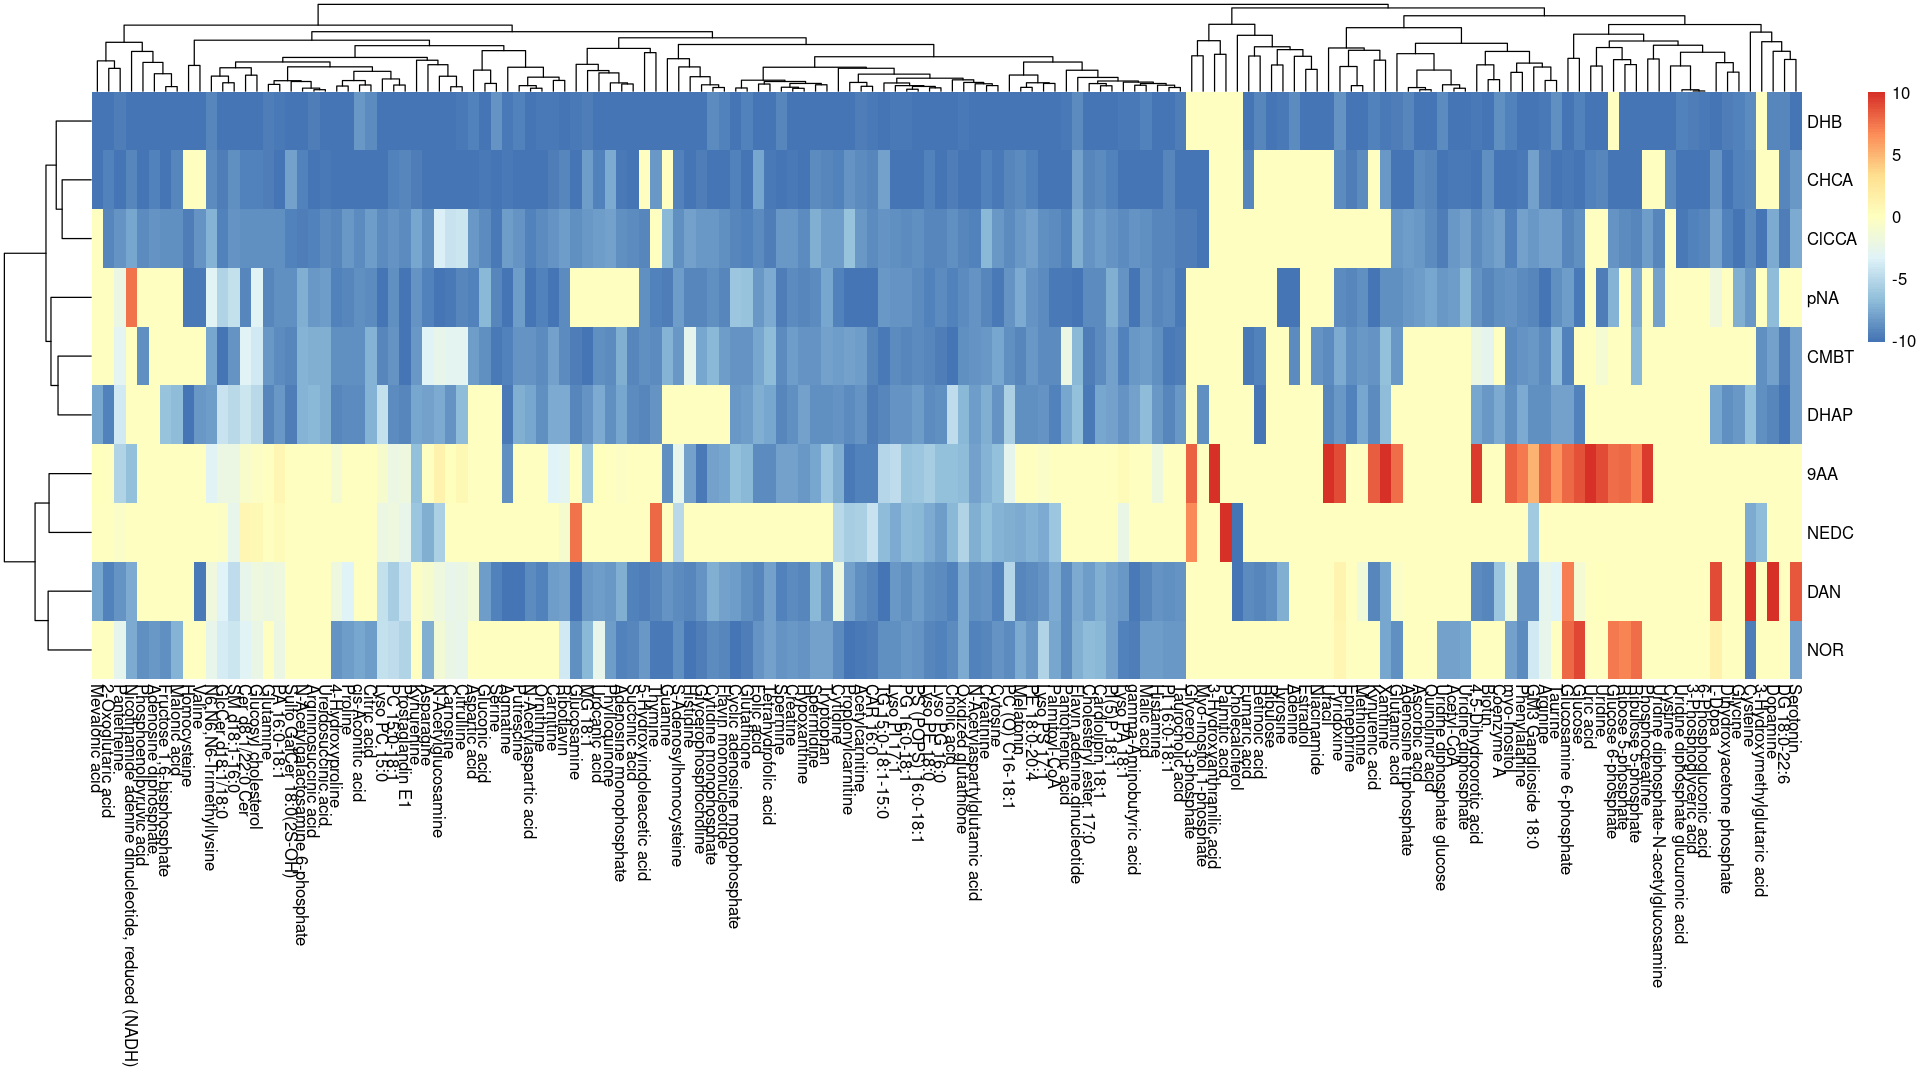

In [41]:
colnames(spotting_data_summary_mat)[-1] <- unique(spotting_data_summary$name_short)
rownames(spotting_data_summary_mat) <- spotting_data_summary_mat$matrix
spotting_data_summary_mat$matrix <- NULL

spotting_data_summary_mat[is.na(spotting_data_summary_mat)] <- 0

heatmap_a <- pheatmap(spotting_data_summary_mat)

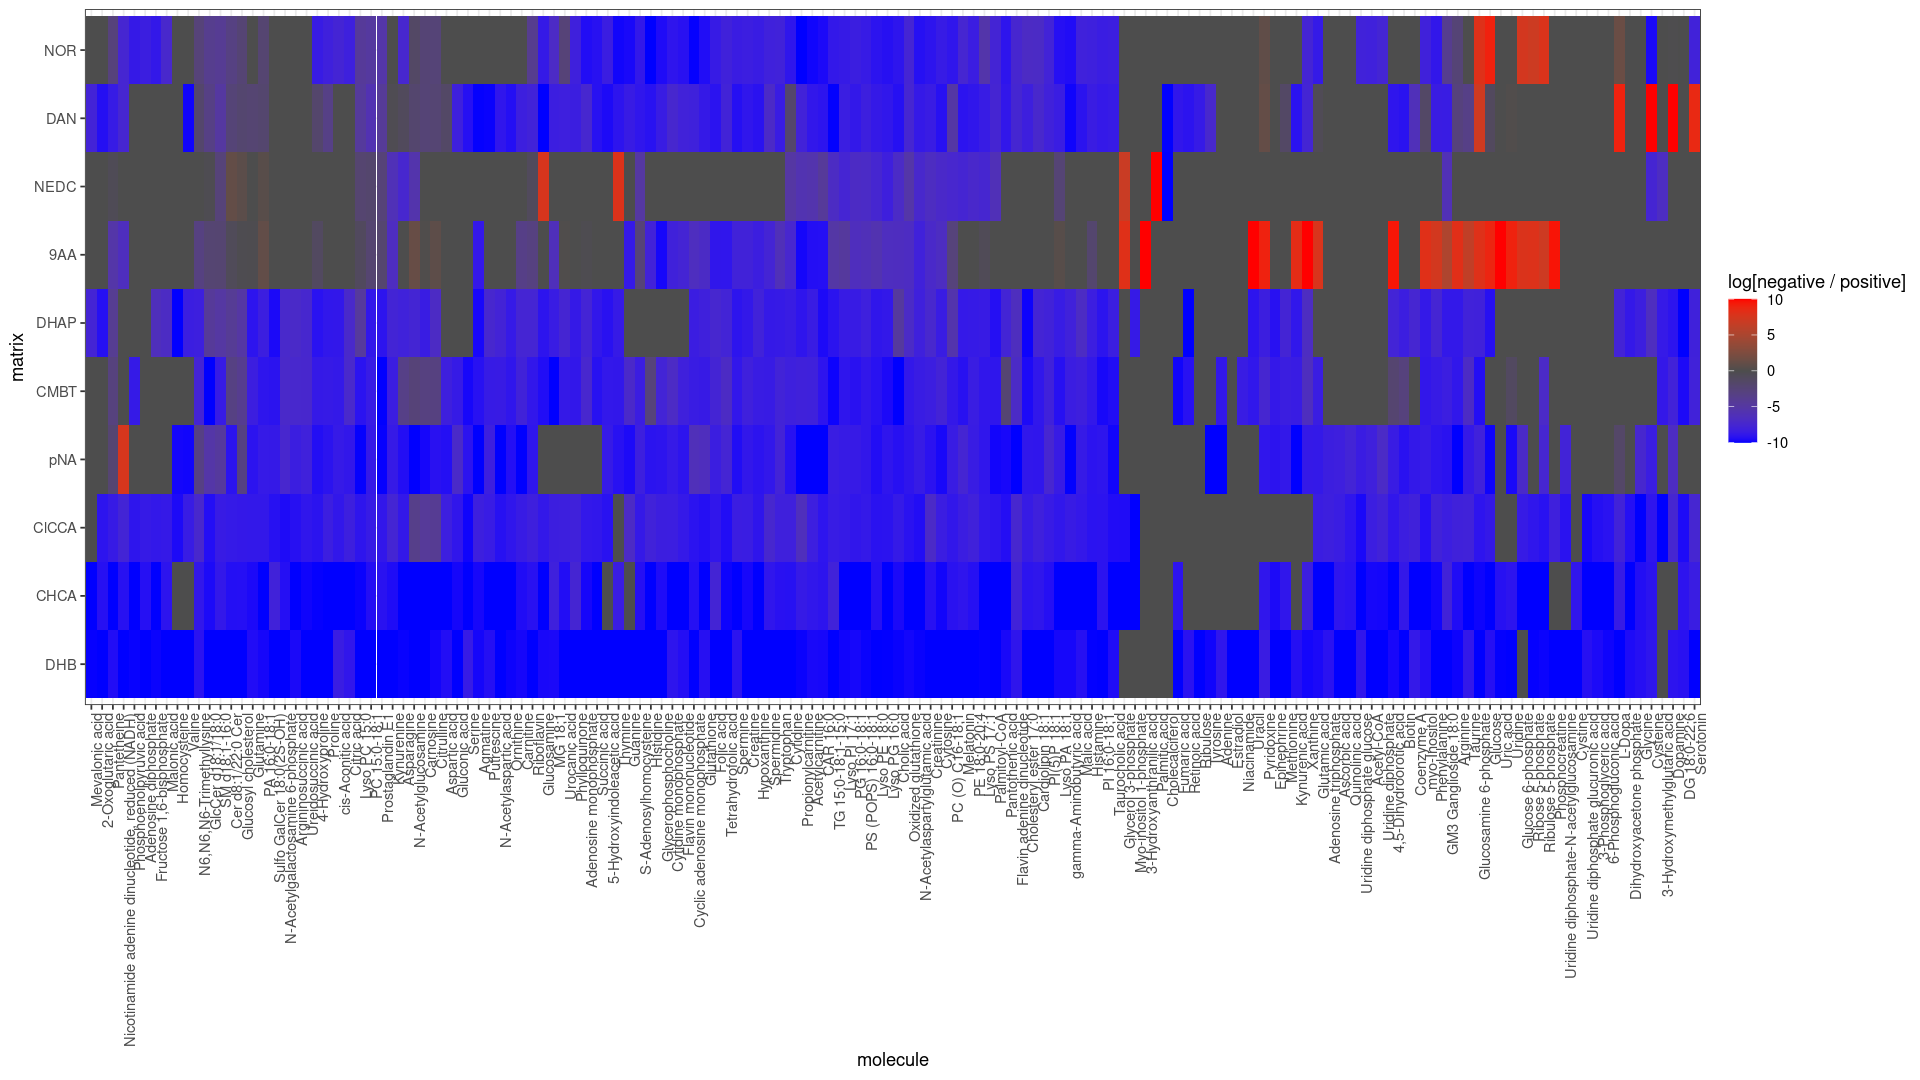

In [48]:
## now in ggplot style

## keep order of the prev heatmap
spotting_data_summary$matrix <- factor(spotting_data_summary$matrix, levels = heatmap_a$tree_row$labels[heatmap_a$tree_row$order])
spotting_data_summary$name_short <- factor(spotting_data_summary$name_short, levels = heatmap_a$tree_col$labels[heatmap_a$tree_col$order])

ggplot(data = spotting_data_summary, 
       aes(x = name_short, 
           y = matrix, 
           fill = log_neg_pos))+
  #geom_bar(stat = "identity")+
  geom_tile()+
  scale_fill_gradient2(low = "blue", high = "red",mid = "gray30", 
                       midpoint = 0, na.value = "white", limits = c(-10,10),
                                  oob = scales::squish)+

  labs(fill = "log[negative / positive]", x = "molecule", y = "matrix")+
  theme_bw()+
  theme(axis.text.x = element_text(angle = 90, hjust = 1))

In [49]:
## define training and validtion set
sampling <- sample(unique(spotting_data_summary$name_short))
train <- sampling[1:round(length(sampling) * (2 / 3))]
validate <-  sampling[(1+round(length(sampling) * (2 / 3))):length(sampling)]

### predict by fingerprint-bits

In [50]:
## translate fingerprints into PCA, add to  spotting_data_summary
## first, use only fingerprint-bits as predictors

fingerprints_matrix <- as.matrix(fingerprints[,bit_columns])

colnames(fingerprints_matrix) <- NULL
rownames(fingerprints_matrix) <-fingerprints$mol_name

fingerprints_matrix_pca <- prcomp(fingerprints_matrix, center = T, scale = T)

fingerprints_matrix_df <- data.frame(name_short = fingerprints$name_short,
                                     fingerprints_matrix_pca$x[,1:100], check.names = F)

In [51]:
spotting_data_summary_bits <- 
  left_join(x = spotting_data_summary,
            y = fingerprints_matrix_df,by = 'name_short')

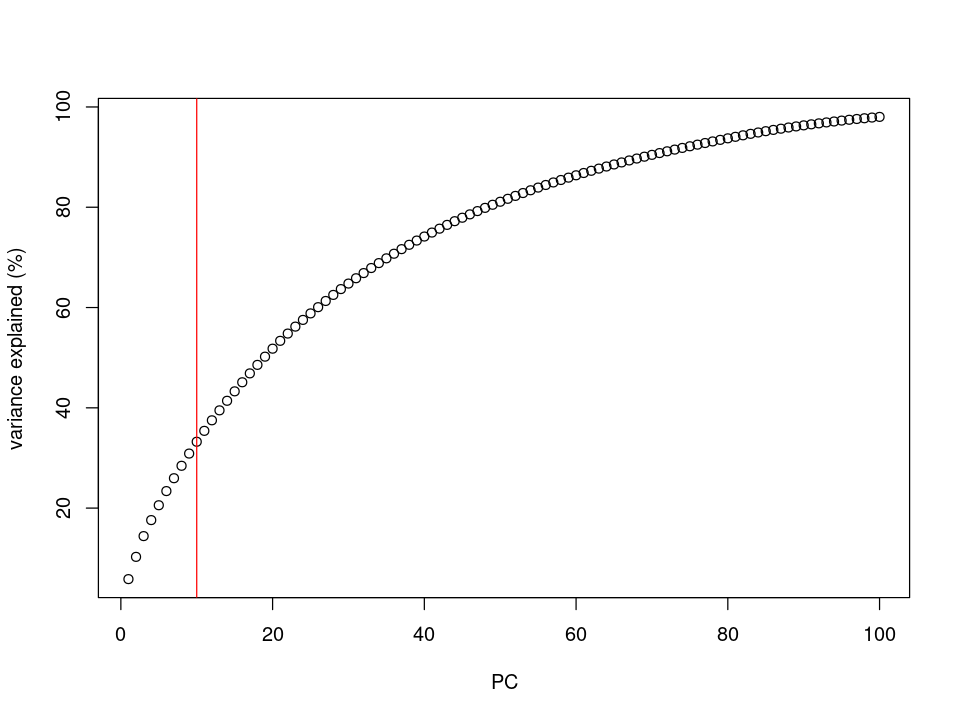

In [52]:
options(repr.plot.width=8, repr.plot.height=6)

## how many PCs to include in model?
n_PC <- 10

plot(summary(fingerprints_matrix_pca)$importance[3,1:100] * 100, xlab = "PC", ylab = "variance explained (%)")
abline(v = n_PC, col = "red")

In [53]:
### one lineair model per matrix/polarity

lm_prediction_validation <-
  sapply(spotting_data_summary_bits %>% ungroup() %>% group_split(matrix), function(i) {
    
    prediction_formula <-
      as.formula(paste0(
        'log_neg_pos ~',
        paste0('PC', 1:n_PC, collapse = " + ")
      ))
    
    train_i <- i[i$name_short %in% train, ]
    validate_i <- i[i$name_short %in% validate, ]
    
    model <- lm(data = train_i,
                formula = prediction_formula)
    
    ## output only validation
    data.frame(
      i[1, 1],
      name_short = validate_i$name_short,
      log_neg_pos = validate_i$log_neg_pos,
      predicted = predict(model, newdata = validate_i)
    )
    
    
  }, simplify = F) %>% bind_rows()

In [54]:
### for comparison, also one kNN regression model per matrix/polarity

knn_prediction_validation <-
  sapply(spotting_data_summary_bits %>% ungroup() %>% group_split(matrix), function(i) {
    train_i <- i[i$name_short %in% train, ]
    validate_i <- i[i$name_short %in% validate, ]
    
    model <- knnreg(y = train_i$log_neg_pos,
                    x = train_i[,c(paste0("PC",1:n_PC))],
                    k = 5)     ### mean of 5 neighbors, is arbitrary
   
    ## output only validation
    data.frame(
       i[1, 1],
       name_short = validate_i$name_short,
       log_neg_pos = validate_i$log_neg_pos,
       predicted = predict(model, newdata = validate_i[,c(paste0("PC",1:n_PC))])
    )
    
    
  }, simplify = F) %>% bind_rows()

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'



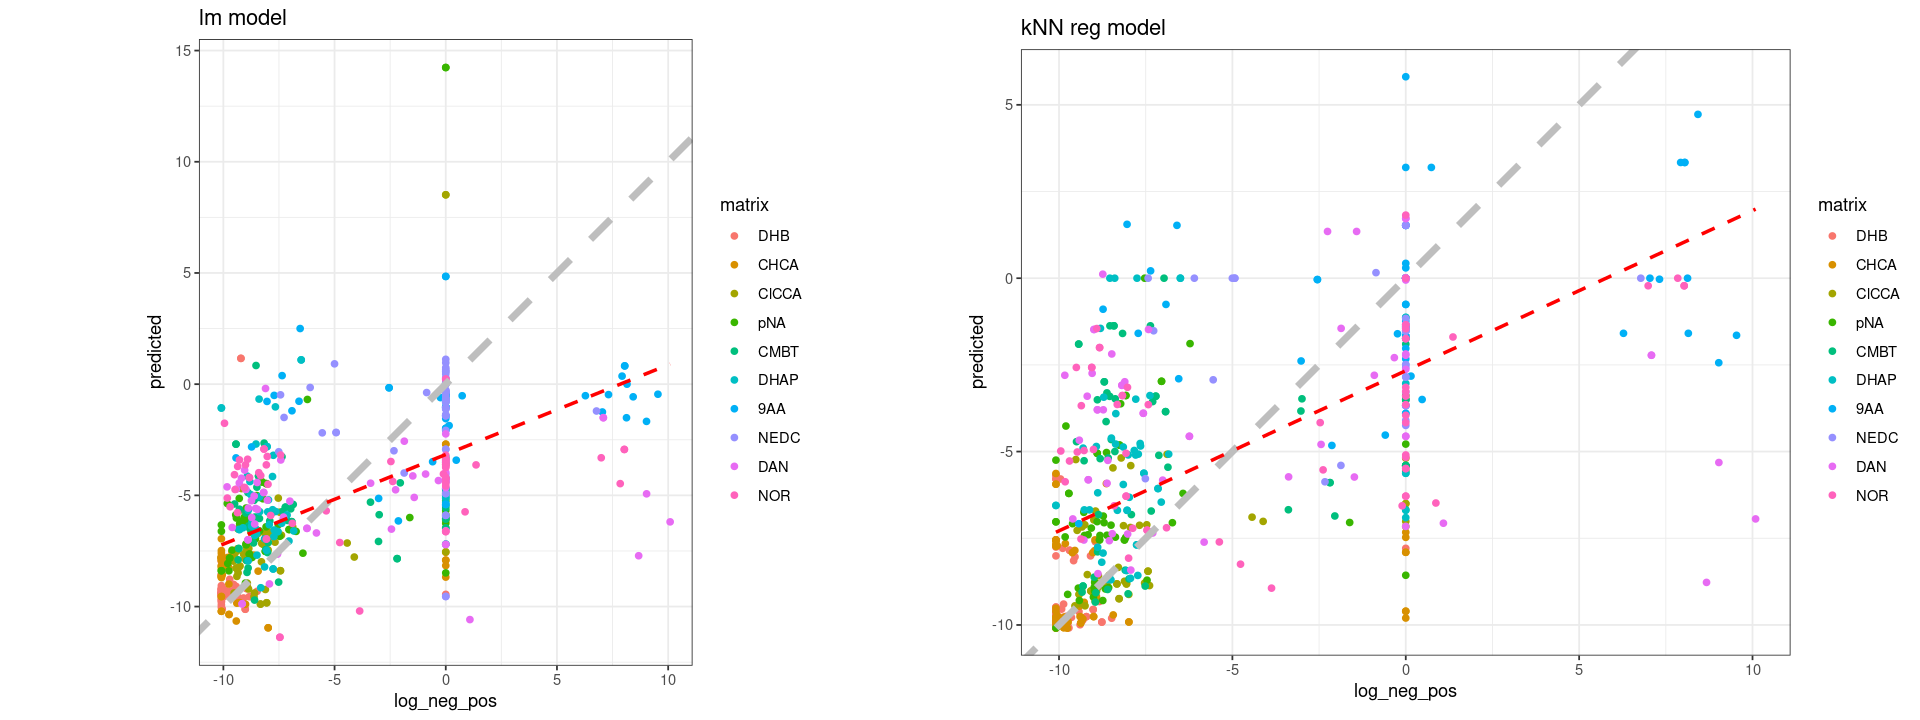

In [55]:
options(repr.plot.width=16, repr.plot.height=6)

plot_grid(
ggplot(data = lm_prediction_validation, 
       aes(x = log_neg_pos, y = predicted, color = matrix))+
  geom_point()+
  geom_abline(slope = 1, linetype =2, color = "gray", size =2 )+ 
  geom_smooth(method = "lm", se = F, aes(group = 1), linetype = 2, color = "red")+
  coord_fixed()+
  labs(title = "lm model")+
  theme_bw()+
  scale_shape_manual(values = c(17,21)),
ggplot(data = knn_prediction_validation, 
       aes(x = log_neg_pos, y = predicted,  color = matrix))+
  geom_point()+
  geom_abline(slope = 1, linetype =2, color = "gray", size =2 )+ 
  geom_smooth(method = "lm", se = F, aes(group = 1), linetype = 2, color = "red")+
  coord_fixed()+
  labs(title = "kNN reg model")+
  theme_bw()+
  scale_shape_manual(values = c(17,21)))

In [56]:
## lm model performance:

## overall
lm_prediction_validation %>% #group_by(polarity,matrix ) %>% 
  summarise(r = cor(predicted, log_neg_pos)) 

## per polarity / matrix
lm_prediction_validation %>% group_by(matrix ) %>% 
  summarise(r = cor(predicted, log_neg_pos)) %>%
  arrange(desc(r))



r
<dbl>
0.5669466


matrix,r
<fct>,<dbl>
ClCCA,0.599019393
pNA,0.473101523
CHCA,0.417621966
NOR,0.233789095
DAN,0.191463903
9AA,0.137589202
DHAP,0.047376233
DHB,0.038443653
CMBT,0.032487498


In [57]:
## kNN reg model performance:

## overall
knn_prediction_validation %>% #group_by(polarity,matrix ) %>% 
  summarise(r = cor(predicted, log_neg_pos)) 

## per polarity / matrix
knn_prediction_validation %>% group_by(matrix ) %>% 
  summarise(r = cor(predicted, log_neg_pos)) %>%
  arrange(desc(r))



r
<dbl>
0.6256502


matrix,r
<fct>,<dbl>
ClCCA,0.52542441
NOR,0.43622935
pNA,0.42996944
DHAP,0.35876349
9AA,0.27939710
CMBT,0.17438513
DAN,0.15902020
NEDC,0.15153339
CHCA,0.09326730


In [59]:
# show orignal data and predictions in heatmaps


plotsABC <- {
 AB <- knn_prediction_validation %>% 
  mutate(matrix = factor(matrix, levels = levels(spotting_data_summary$matrix)),
         name_short = factor(name_short,  levels = heatmap_a$tree_col$labels[heatmap_a$tree_col$order])) %>% {
  A <- ggplot(data = ., 
         aes(x = name_short, 
             y = matrix, 
             fill = log_neg_pos))+
    geom_tile(show.legend = F)+
    scale_fill_gradient2(low = "blue", high = "red",mid = "gray30", 
                       midpoint = 0, na.value = "white", limits = c(-10,10),
                                  oob = scales::squish)+
    labs(fill = "relative signal", x = "", y = "matrix", title = "validation set")+
    theme_bw()+
    theme(axis.text.x = element_blank())
  
  B <- ggplot(data = ., 
              aes(x = name_short, 
                  y = matrix, 
                  fill = predicted))+
    geom_tile(show.legend = F)+
   scale_fill_gradient2(low = "blue", high = "red",mid = "gray30", 
                       midpoint = 0, na.value = "white", limits = c(-10,10),
                                  oob = scales::squish)+
    labs(fill = "relative signal", x = "", y = "matrix", 
         title = "kNN regression", subtitle = knn_prediction_validation %>% #group_by(polarity,matrix ) %>% 
           summarise(r = paste0("r = ",format(cor(predicted, log_neg_pos), digit =3))) %>%
           pull(r) )+
    theme_bw()+
    theme(axis.text.x = element_blank())
  
  list(A,B)
         }
  
  C <-
    lm_prediction_validation %>% 
    mutate(matrix = factor(matrix, levels = levels(spotting_data_summary$matrix)),
           name_short = factor(name_short,  levels = heatmap_a$tree_col$labels[heatmap_a$tree_col$order])) %>% {
             
             C <- ggplot(data = ., 
                         aes(x = name_short, 
                             y = matrix, 
                             fill = predicted))+
               #geom_bar(stat = "identity")+
               geom_tile(show.legend = F)+
               scale_fill_gradient2(low = "blue", high = "red",mid = "gray30", 
                       midpoint = 0, na.value = "white", limits = c(-10,10),
                                  oob = scales::squish)+
               labs(fill = "relative signal", x = "molecule", y = "matrix", 
                    title = "lm regression",subtitle = lm_prediction_validation %>% #group_by(polarity,matrix ) %>% 
                      summarise(r = paste0("r = ",format(cor(predicted, log_neg_pos), digit =3))) %>%
                      pull(r))+
               theme_bw()+
               theme(axis.text.x = element_text(angle = 90, hjust = 1))
             
             C
           }
  
  list(A = AB[[1]],
       B = AB[[2]],
       C = C)
  
}


plotsABC <- plot_grid(ggdraw()+draw_label('predictors: fingerprint-bits', 
                                          fontface = "bold"),
                      plotsABC[[1]],plotsABC[[2]],plotsABC[[3]], scale = 1, hjust = -2, vjust = 1,
                      align = "v", ncol = 1, rel_heights = c(.1,1,1,1.7))+ 
            theme(plot.background = element_rect(fill = "white", colour = NA))

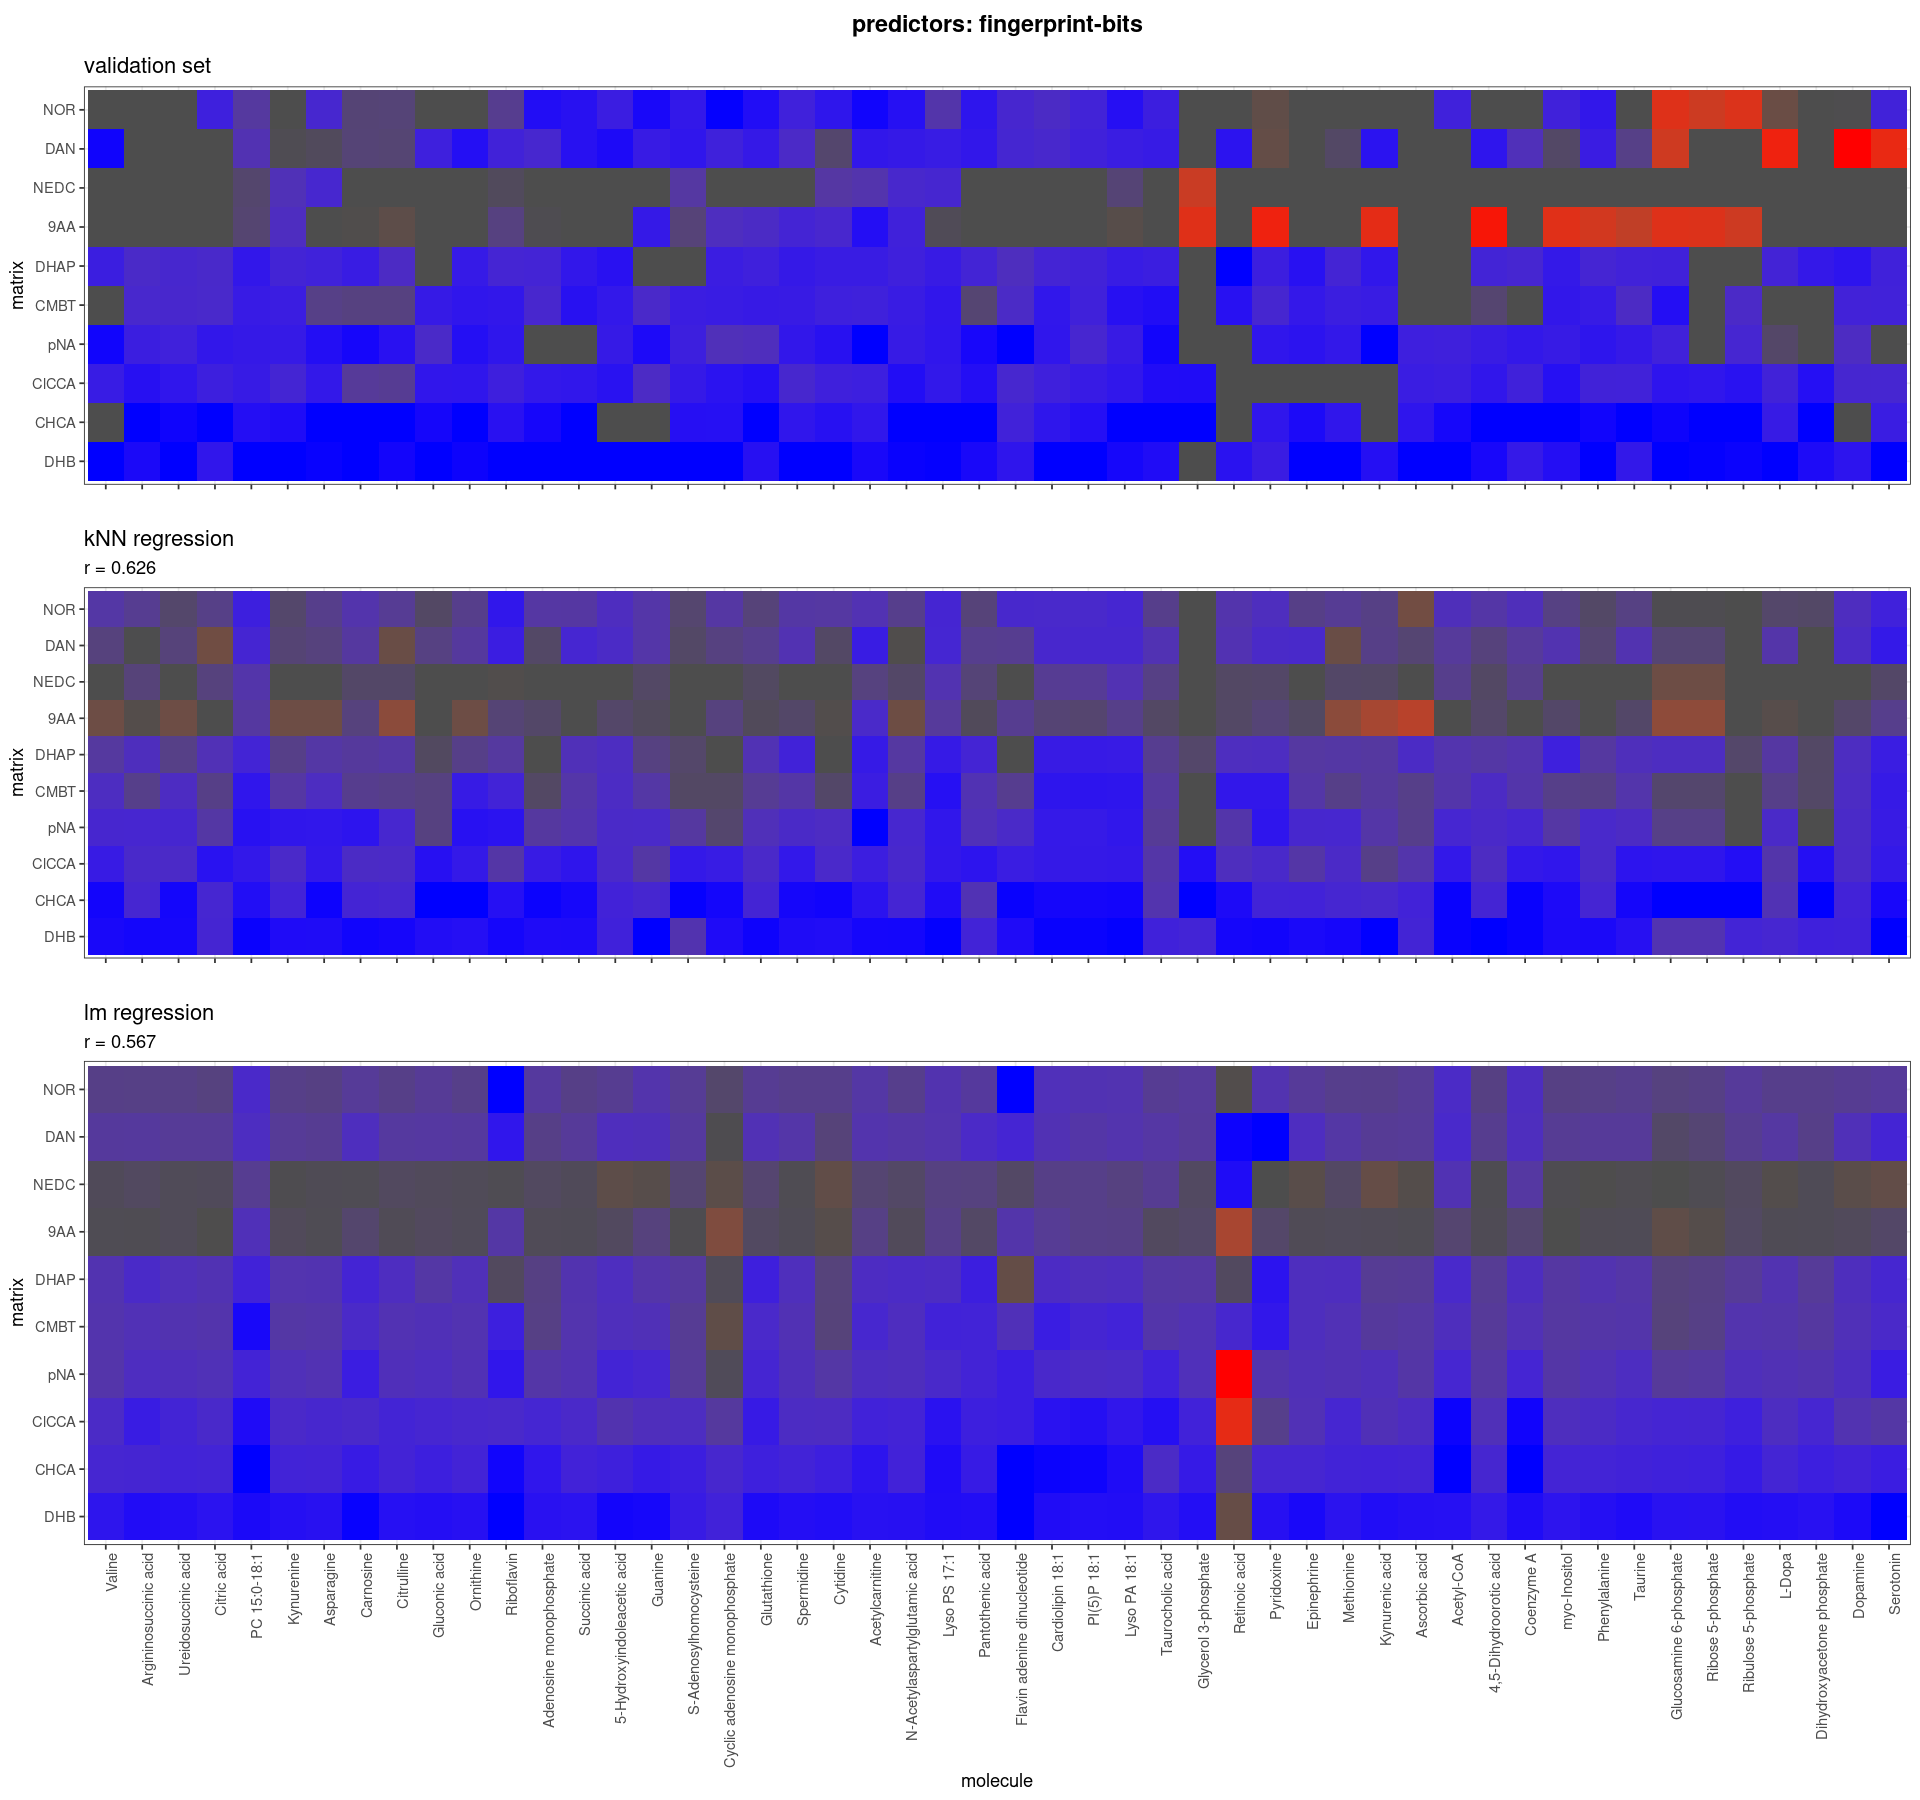

In [60]:
options(repr.plot.width=16, repr.plot.height=15)

plotsABC

In [25]:
## save plot as PNG

#save_plot(plotsABC, filename = "matrix_prediction_validation_bits.png", base_height = 12, base_width = 7)

### predict by bits and phys properties

In [61]:
## translate fingerprints into PCA, add to  spotting_data_summary
## first, use only fingerprint-bits as predictors

fingerprints_matrix <- as.matrix(fingerprints[,c(bit_columns, phys_columns)])

colnames(fingerprints_matrix) <- NULL
rownames(fingerprints_matrix) <-fingerprints$mol_name

fingerprints_matrix_pca <- prcomp(fingerprints_matrix, center = T, scale = T)

fingerprints_matrix_df <- data.frame(name_short = fingerprints$name_short,
                                     fingerprints_matrix_pca$x[,1:100], check.names = F)

In [62]:
spotting_data_summary_bits_phys <- 
  left_join(x = spotting_data_summary,
            y = fingerprints_matrix_df,by = 'name_short')

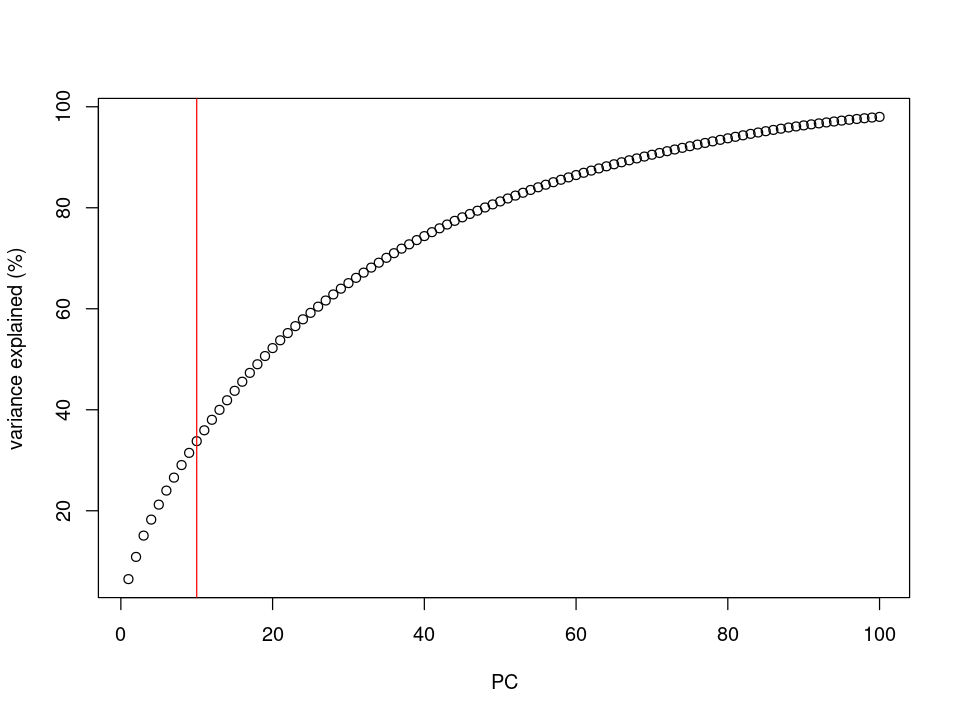

In [63]:
options(repr.plot.width=8, repr.plot.height=6)

## how many PCs to include in model?
n_PC <- 10

plot(summary(fingerprints_matrix_pca)$importance[3,1:100] * 100, xlab = "PC", ylab = "variance explained (%)")
abline(v = n_PC, col = "red")

In [64]:


### one lineair model per matrix/polarity

lm_prediction_validation <-
  sapply(spotting_data_summary_bits %>% ungroup() %>% group_split(matrix), function(i) {
    
    prediction_formula <-
      as.formula(paste0(
        'log_neg_pos ~',
        paste0('PC', 1:n_PC, collapse = " + ")
      ))
    
    train_i <- i[i$name_short %in% train, ]
    validate_i <- i[i$name_short %in% validate, ]
    
    model <- lm(data = train_i,
                formula = prediction_formula)
    
    ## output only validation
    data.frame(
      i[1, 1],
      name_short = validate_i$name_short,
      log_neg_pos = validate_i$log_neg_pos,
      predicted = predict(model, newdata = validate_i)
    )
    
    
  }, simplify = F) %>% bind_rows()

In [65]:
### for comparison, also one kNN regression model per matrix/polarity

knn_prediction_validation <-
  sapply(spotting_data_summary_bits %>% ungroup() %>% group_split(matrix), function(i) {
    train_i <- i[i$name_short %in% train, ]
    validate_i <- i[i$name_short %in% validate, ]
    
    model <- knnreg(y = train_i$log_neg_pos,
                    x = train_i[,c(paste0("PC",1:n_PC))],
                    k = 5)     ### mean of 5 neighbors, is arbitrary
   
    ## output only validation
    data.frame(
       i[1, 1],
       name_short = validate_i$name_short,
       log_neg_pos = validate_i$log_neg_pos,
       predicted = predict(model, newdata = validate_i[,c(paste0("PC",1:n_PC))])
    )
    
    
  }, simplify = F) %>% bind_rows()

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'



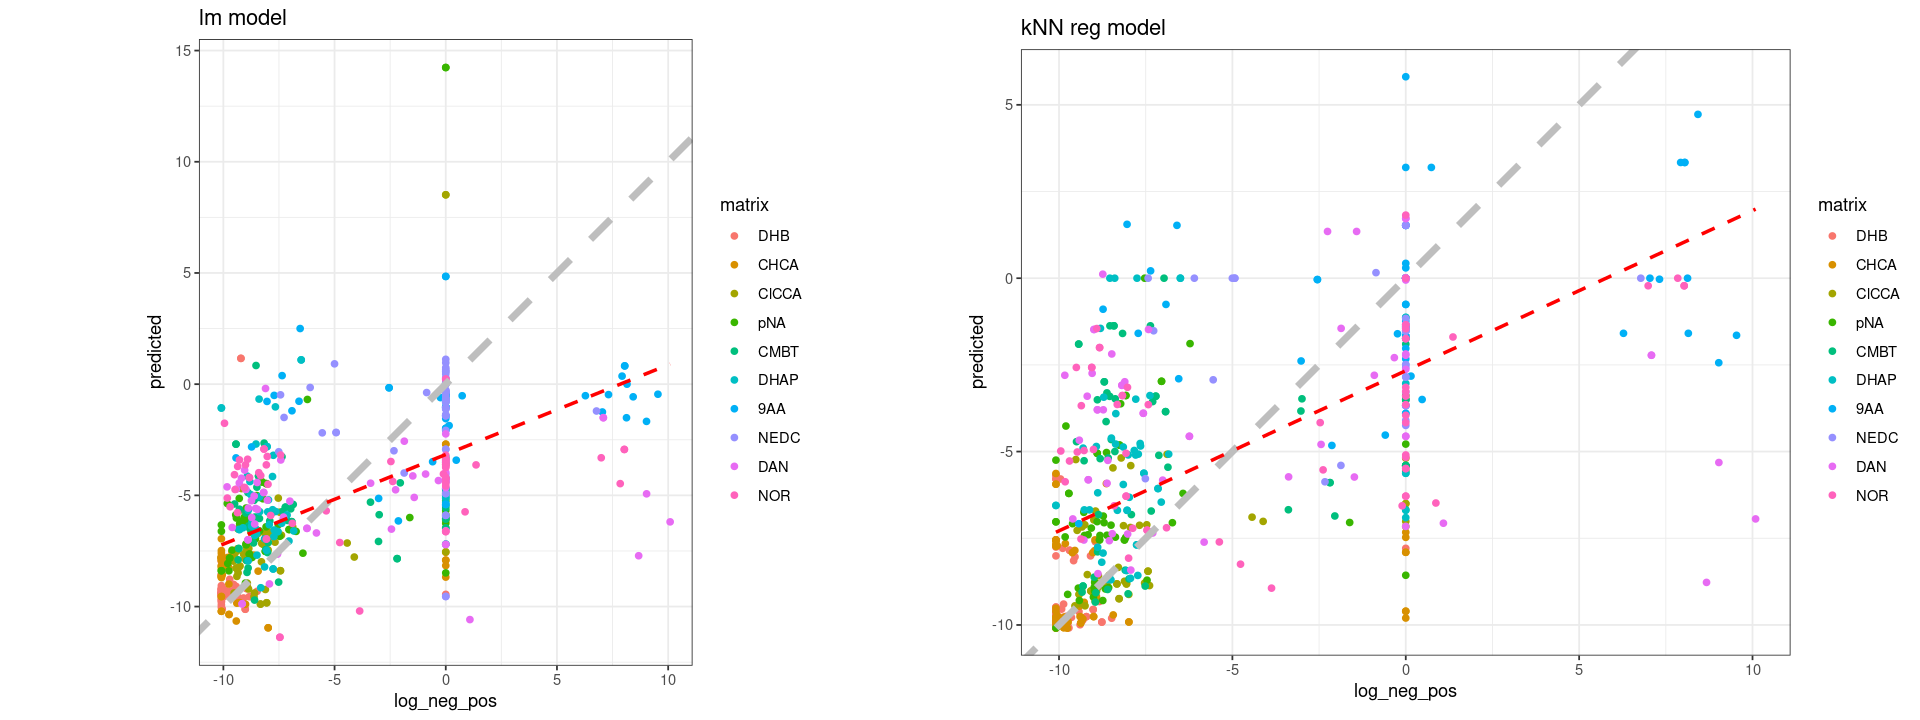

In [66]:
options(repr.plot.width=16, repr.plot.height=6)

plot_grid(
ggplot(data = lm_prediction_validation, 
       aes(x = log_neg_pos, y = predicted, color = matrix))+
  geom_point()+
  geom_abline(slope = 1, linetype =2, color = "gray", size =2 )+ 
  geom_smooth(method = "lm", se = F, aes(group = 1), linetype = 2, color = "red")+
  coord_fixed()+
  labs(title = "lm model")+
  theme_bw()+
  scale_shape_manual(values = c(17,21)),
ggplot(data = knn_prediction_validation, 
       aes(x = log_neg_pos, y = predicted,  color = matrix))+
  geom_point()+
  geom_abline(slope = 1, linetype =2, color = "gray", size =2 )+ 
  geom_smooth(method = "lm", se = F, aes(group = 1), linetype = 2, color = "red")+
  coord_fixed()+
  labs(title = "kNN reg model")+
  theme_bw()+
  scale_shape_manual(values = c(17,21)))

In [67]:
## lm model performance:

## overall
lm_prediction_validation %>% #group_by(polarity,matrix ) %>% 
  summarise(r = cor(predicted, log_neg_pos)) 

## per polarity / matrix
lm_prediction_validation %>% group_by(matrix ) %>% 
  summarise(r = cor(predicted, log_neg_pos)) %>%
  arrange(desc(r))



r
<dbl>
0.5669466


matrix,r
<fct>,<dbl>
ClCCA,0.599019393
pNA,0.473101523
CHCA,0.417621966
NOR,0.233789095
DAN,0.191463903
9AA,0.137589202
DHAP,0.047376233
DHB,0.038443653
CMBT,0.032487498


In [68]:
## kNN reg model performance:

## overall
knn_prediction_validation %>% #group_by(polarity,matrix ) %>% 
  summarise(r = cor(predicted, log_neg_pos)) 

## per polarity / matrix
knn_prediction_validation %>% group_by(matrix ) %>% 
  summarise(r = cor(predicted, log_neg_pos)) %>%
  arrange(desc(r))



r
<dbl>
0.6256502


matrix,r
<fct>,<dbl>
ClCCA,0.52542441
NOR,0.43622935
pNA,0.42996944
DHAP,0.35876349
9AA,0.27939710
CMBT,0.17438513
DAN,0.15902020
NEDC,0.15153339
CHCA,0.09326730


In [69]:
# show orignal data and predictions in heatmaps


plotsABC <- {
 AB <- knn_prediction_validation %>% 
  mutate(matrix = factor(matrix, levels = levels(spotting_data_summary$matrix)),
         name_short = factor(name_short,  levels = heatmap_a$tree_col$labels[heatmap_a$tree_col$order])) %>% {
  A <- ggplot(data = ., 
         aes(x = name_short, 
             y = matrix, 
             fill = log_neg_pos))+
    geom_tile(show.legend = F)+
    scale_fill_gradient2(low = "blue", high = "red",mid = "gray30", 
                       midpoint = 0, na.value = "white", limits = c(-10,10),
                                  oob = scales::squish)+
    labs(fill = "relative signal", x = "", y = "matrix", title = "validation set")+
    theme_bw()+
    theme(axis.text.x = element_blank())
  
  B <- ggplot(data = ., 
              aes(x = name_short, 
                  y = matrix, 
                  fill = predicted))+
    geom_tile(show.legend = F)+
    scale_fill_gradient2(low = "blue", high = "red",mid = "gray30", 
                       midpoint = 0, na.value = "white", limits = c(-10,10),
                                  oob = scales::squish)+
    labs(fill = "relative signal", x = "", y = "matrix", 
         title = "kNN regression", subtitle = knn_prediction_validation %>% #group_by(polarity,matrix ) %>% 
           summarise(r = paste0("r = ",format(cor(predicted, log_neg_pos), digit =3))) %>%
           pull(r) )+
    theme_bw()+
    theme(axis.text.x = element_blank())
  
  list(A,B)
         }
  
  C <-
    lm_prediction_validation %>% 
    mutate(matrix = factor(matrix, levels = levels(spotting_data_summary$matrix)),
           name_short = factor(name_short,  levels = heatmap_a$tree_col$labels[heatmap_a$tree_col$order])) %>% {
             
             C <- ggplot(data = ., 
                         aes(x = name_short, 
                             y = matrix, 
                             fill = predicted))+
               #geom_bar(stat = "identity")+
               geom_tile(show.legend = F)+
              scale_fill_gradient2(low = "blue", high = "red",mid = "gray30", 
                       midpoint = 0, na.value = "white", limits = c(-10,10),
                                  oob = scales::squish)+
               labs(fill = "relative signal", x = "molecule", y = "matrix", 
                    title = "lm regression",subtitle = lm_prediction_validation %>% #group_by(polarity,matrix ) %>% 
                      summarise(r = paste0("r = ",format(cor(predicted, log_neg_pos), digit =3))) %>%
                      pull(r))+
               theme_bw()+
               theme(axis.text.x = element_text(angle = 90, hjust = 1))
             
             C
           }
  
  list(A = AB[[1]],
       B = AB[[2]],
       C = C)
  
}


plotsABC <- plot_grid(ggdraw()+draw_label('predictors: fingerprint-bits', 
                                          fontface = "bold"),
                      plotsABC[[1]],plotsABC[[2]],plotsABC[[3]], scale = 1, hjust = -2, vjust = 1,
                      align = "v", ncol = 1, rel_heights = c(.1,1,1,1.7))+ 
            theme(plot.background = element_rect(fill = "white", colour = NA))

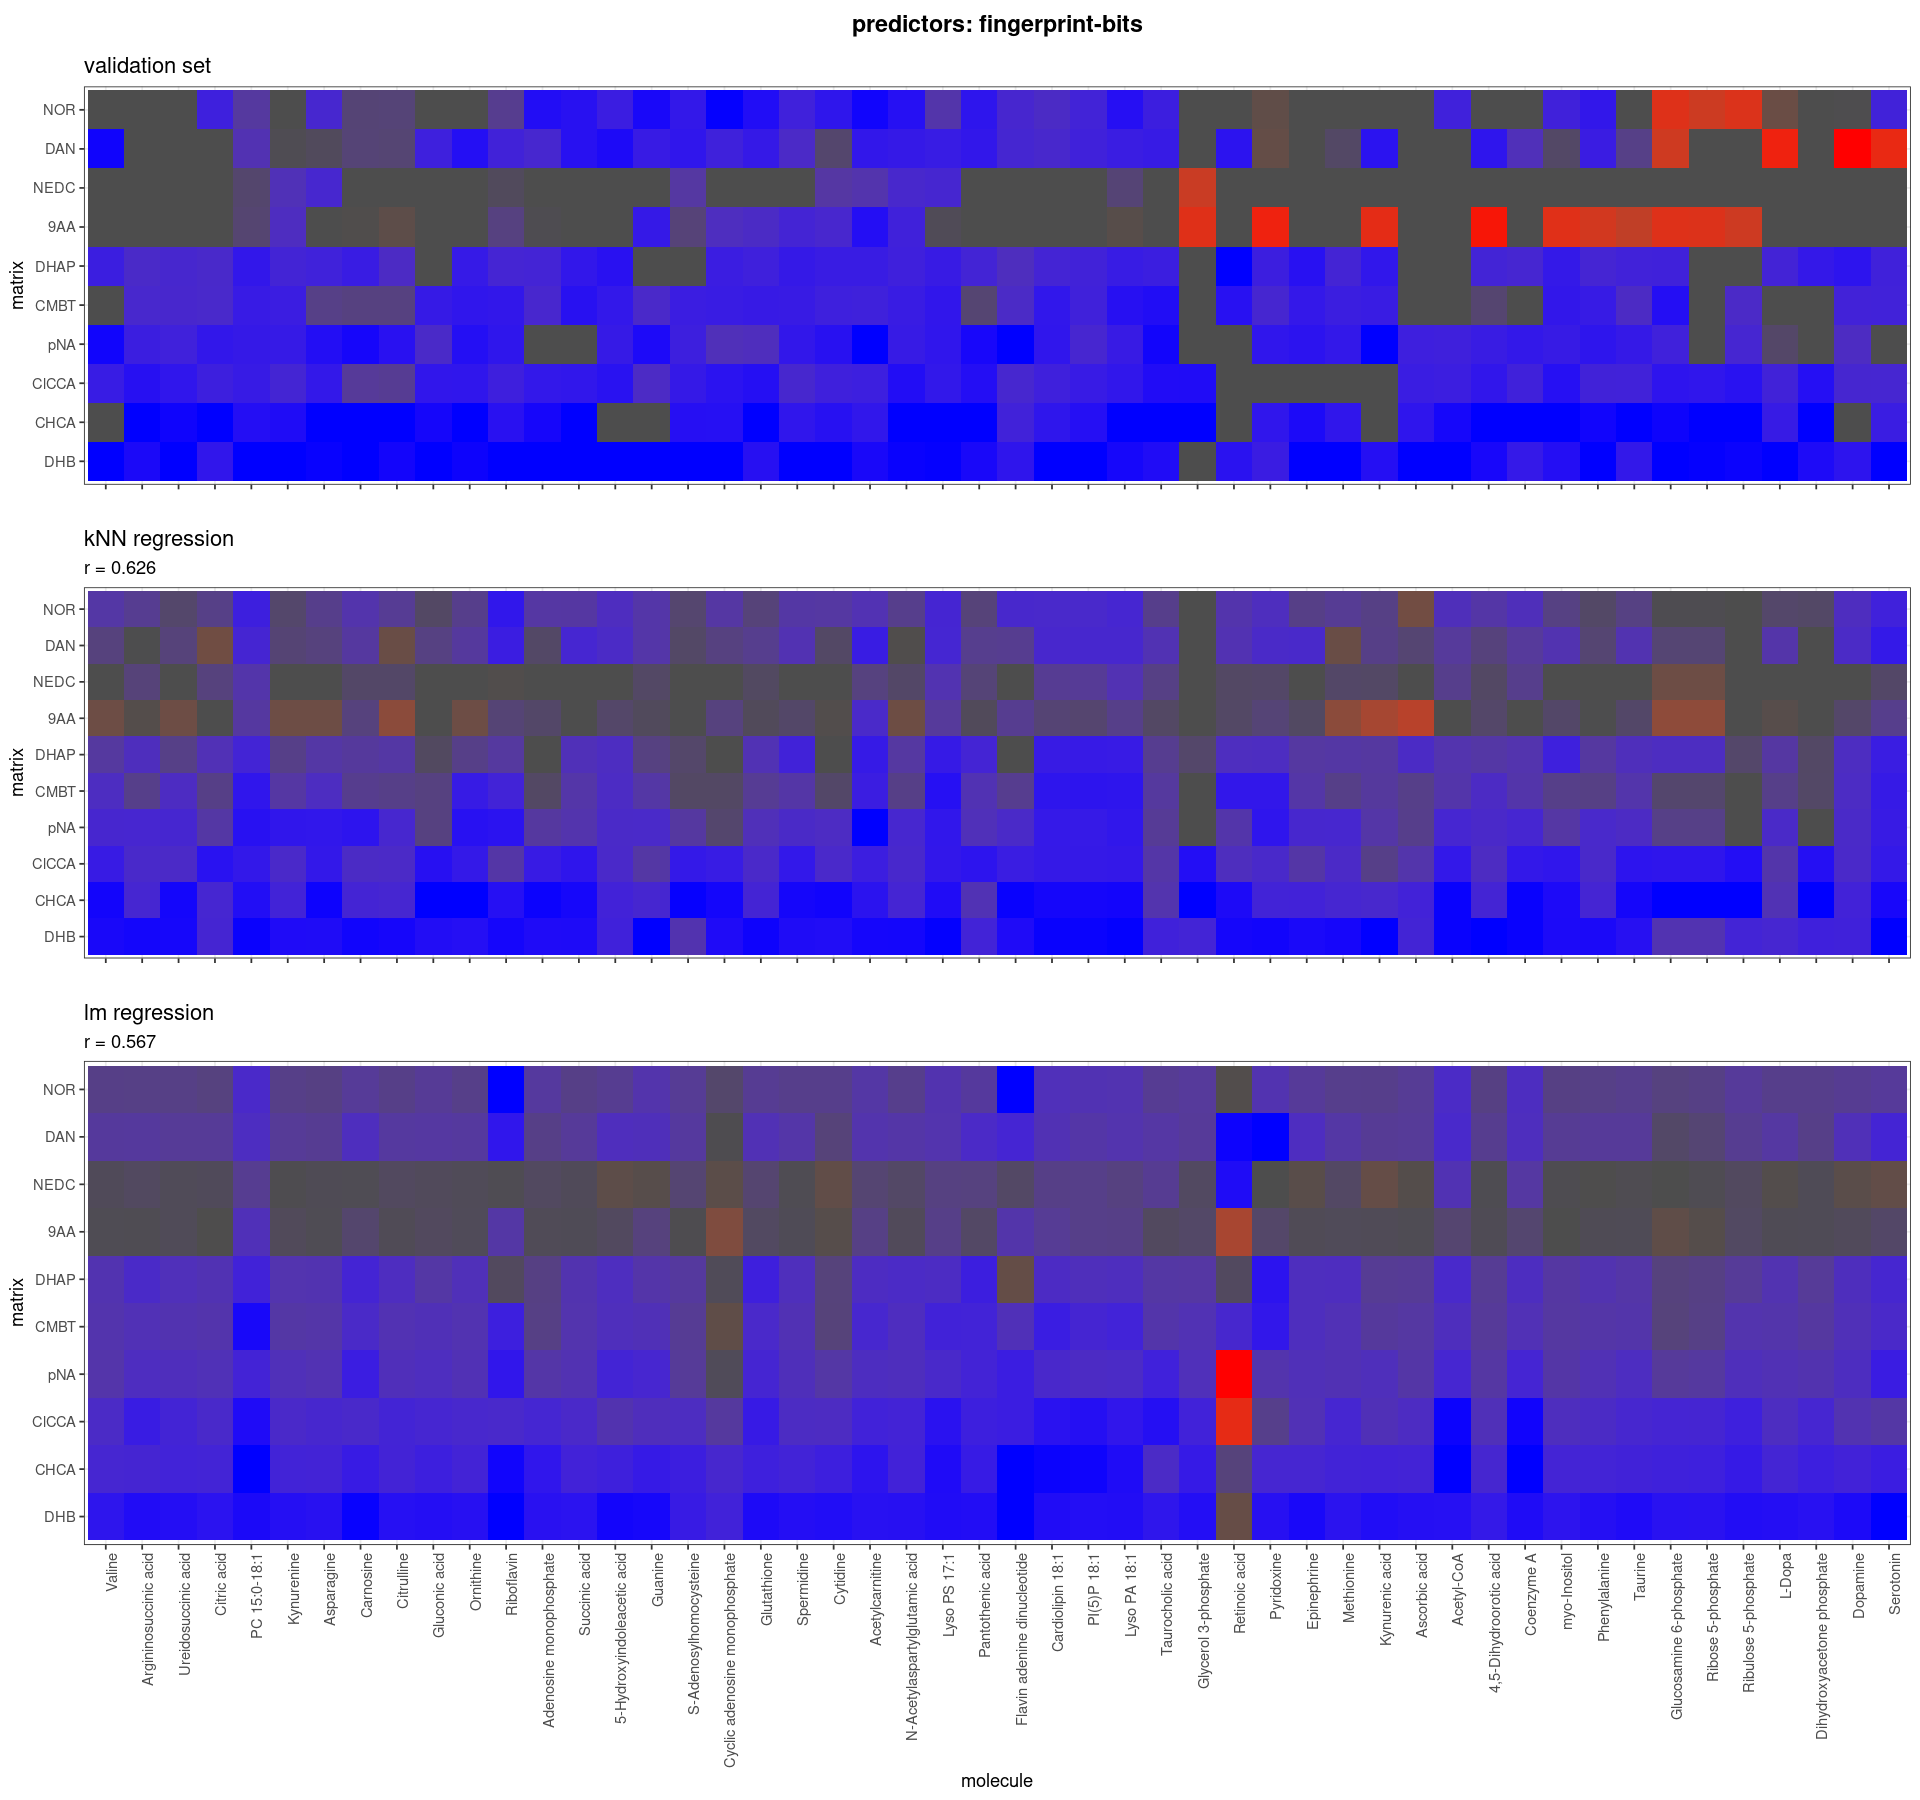

In [70]:
options(repr.plot.width=16, repr.plot.height=15)

plotsABC

In [36]:
## save plot as PNG

#save_plot(plotsABC, filename = "matrix_prediction_validation_bits_phys.png", base_height = 12, base_width = 7)

## predict unknown molecule with kNNreg model

In [71]:
## input fingerprints

finger_prints <- data.frame(unknown1 = as.integer(sample(c(0,1), size = 365, replace = T)),
                            unknown2 = as.integer(sample(c(0,1), size = 365, replace = T)))

t(finger_prints)

unknown1,1,0,0,0,1,1,1,1,1,1,⋯,0,0,0,0,1,0,1,0,1,0
unknown2,1,0,1,1,0,0,1,1,0,0,⋯,0,1,1,1,1,0,1,1,0,0


In [72]:
### translate into PCA with the earlier model

pca_s <- predict(fingerprints_matrix_pca, newdata = t(finger_prints))
pca_s

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,⋯,PC188,PC189,PC190,PC191,PC192,PC193,PC194,PC195,PC196,PC197
unknown1,-2.140036,-3.799975,-0.1841233,-0.8573323,-1.6878429,-0.324620888,1.9125208,2.420411,-0.6310803,-0.1009368,⋯,0.09450466,-0.04365537,0.3428348,0.4262526,0.5899128,0.007589912,-0.23571471,-0.5798417,-0.27485471,1.0676977
unknown2,-2.159327,-3.231465,-1.7550814,-0.9753607,0.1277544,-0.007591481,0.1639384,2.368299,-0.6014124,-1.1272260,⋯,-0.22683182,-0.14772850,0.2297569,0.1195313,0.6753933,0.027535410,0.05785671,0.3312110,-0.04508601,-0.8843397


In [73]:
## use knn reg models and predict unknowns

knn_prediction <-
  sapply(spotting_data_summary_bits_phys %>% ungroup() %>% group_split(matrix), function(i) {
    train_i <- i   ## use all here
    
    model <- knnreg(y = train_i$log_neg_pos,
                    x = train_i[,c(paste0("PC",1:n_PC))],k =5)
    
    data.frame(
      i[1, 1],
      name_short = rownames(pca_s),
      predicted = predict(model, newdata = as_tibble(pca_s)[,1:n_PC])
    )
    
    
  }, simplify = F) %>% bind_rows()

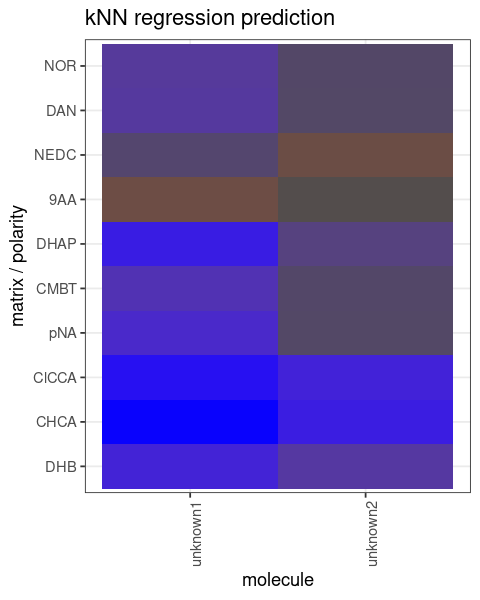

In [74]:
options(repr.plot.width=4, repr.plot.height=5)

knn_prediction %>% 
  mutate(matrix = factor(matrix, levels = levels(spotting_data_summary_bits_phys$matrix))) %>% {
           
           ggplot(data = ., 
                       aes(x = name_short, 
                           y = matrix, 
                           fill = predicted))+
             geom_tile(show.legend = F)+
             scale_fill_gradient2(low = "blue", high = "red",mid = "gray30", 
                       midpoint = 0, na.value = "white", limits = c(-10,10),
                                  oob = scales::squish)+
             labs(fill = "relative signal", x = "molecule", y = "matrix / polarity", 
                  title = "kNN regression prediction")+
             theme_bw()+
             theme(axis.text.x = element_text(angle = 90, hjust = 1))
           
  }



## which bits are predictive?

In [75]:
## generate models again, now use all data to train

lm_prediction_models <-
  sapply(spotting_data_summary_bits_phys %>% ungroup() %>% group_split( matrix), function(i) {
    
    prediction_formula <-
      as.formula(paste0(
        'log_neg_pos ~',
        paste0('PC', 1:n_PC, collapse = " + ")
      ))
    
    train_i <- i   ## use all
    
    
    list(model = lm(data = train_i,
                    formula = prediction_formula),
         mat_pol = train_i$matrix[1])
    
}, simplify = F)

names(lm_prediction_models) <- sapply(lm_prediction_models, function(i){i$mat_pol})

In [76]:
## translate the coefficients of the PCs into the bits
## please double-check whether this is correct...

bit_coefficients <-
sapply(lm_prediction_models, function(mat_pol_model) {
  rowSums(t(
    t(fingerprints_matrix_pca$rotation[, 1:n_PC]) *
      mat_pol_model$model$coefficients[-1]
  ))
}, simplify = T)

rownames(bit_coefficients) <- 1:dim(bit_coefficients)[1]

bit_coefficients[1:10,]

,DHB,CHCA,ClCCA,pNA,CMBT,DHAP,9AA,NEDC,DAN,NOR
1,0.0001340767,-0.0276975582,-0.035614057,-0.0339597671,-0.0461303826,-0.038949831,-0.067475191,-0.044826444,-0.082015288,-0.069029246
2,0.0087947146,-0.0082128281,-0.017108595,-0.0289208613,-0.0004422930,0.005585882,-0.026255208,-0.028894370,-0.035491207,-0.030480127
3,-0.0032457687,-0.0263321549,-0.020044066,-0.0198577193,-0.0436122019,-0.026412024,-0.059989831,-0.031112136,-0.035288375,-0.041436994
4,-0.0332616646,-0.0255741158,0.059319512,-0.2026675286,-0.1601982190,-0.172125757,-0.129535025,-0.044007817,-0.153314260,-0.140280574
5,0.0001108452,0.0001102545,-0.001488008,0.0004007592,0.0046103390,0.002322374,0.005834981,0.002965486,0.006979961,0.006634958
6,0.0051586183,0.0554782144,0.055328828,0.0463820749,-0.0214044021,-0.021141513,0.003420058,0.001942811,-0.045787147,0.025702120
7,0.0074872135,0.0136465179,0.010826489,0.0202311637,0.0003100588,0.001691377,-0.002614044,-0.008347938,-0.016388187,-0.002948212
8,-0.0093301333,-0.0212542940,-0.020635724,-0.0601348842,-0.0251174985,-0.053942656,-0.015834070,-0.035990896,-0.052178637,-0.034726286
9,-0.0001119818,-0.0023831664,-0.001573434,-0.0340750687,-0.0231846213,0.032366792,-0.016074412,0.015457250,-0.047059054,-0.038869928
10,0.0009791700,0.0024400046,0.001953522,0.0180296347,0.0196183730,0.023409960,0.014122032,0.010919230,0.026909929,0.012662397


In [77]:
## into long format...

bit_coefficients_long <- 
   bit_coefficients %>% data.frame(check.names = F) %>% mutate(bit = colnames(fingerprints)[-1]) %>% 
  pivot_longer(cols = 1:10, names_to = "mat_pol") %>%
  mutate(value = value / max(value))

bit_coefficients_long$bit <- factor(bit_coefficients_long$bit, levels = unique(bit_coefficients_long$bit))

bit_coefficients_long[1:10,]

bit,mat_pol,value
<fct>,<chr>,<dbl>
bit#1,DHB,0.0007733113
bit#1,CHCA,-0.1597505777
bit#1,ClCCA,-0.2054103892
bit#1,pNA,-0.1958689774
bit#1,CMBT,-0.2660651600
bit#1,DHAP,-0.2246500560
bit#1,9AA,-0.3891751292
bit#1,NEDC,-0.2585444630
bit#1,DAN,-0.4730377144


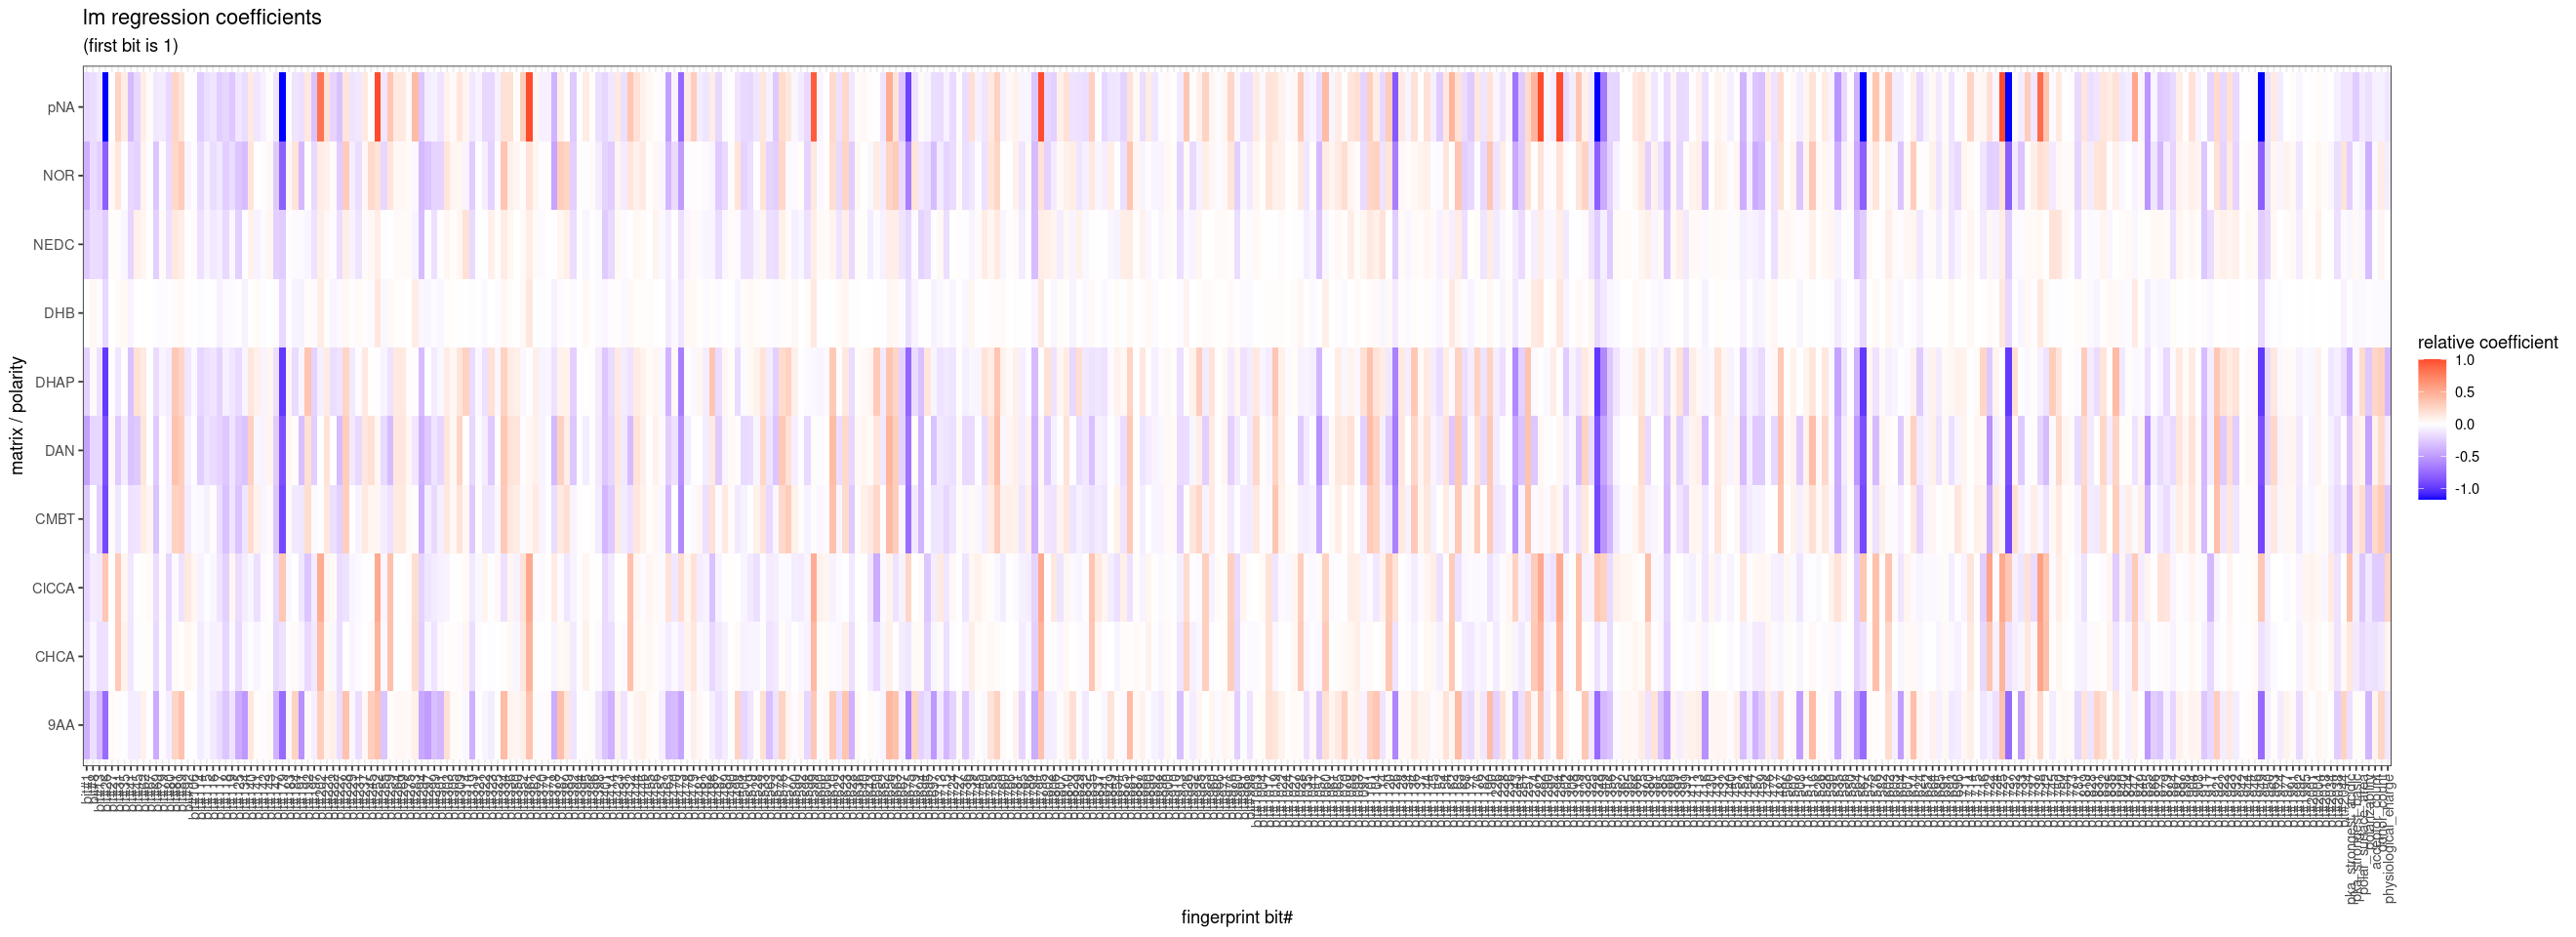

In [78]:
## plot 
options(repr.plot.width=22, repr.plot.height=8)

D <-
bit_coefficients_long %>% #group_by(bit) %>% mutate(max = max(value),
                          #                         min = min(value)) %>%
  #ungroup() %>% filter(max > 0.3 | min < -0.3) %>% 
{
    
    ggplot(data = ., 
           aes(x = as.factor(bit), 
               y = mat_pol, 
               fill = value))+
      geom_tile(show.legend = T)+
      scale_fill_gradient2(low = "blue",mid = "white", midpoint = 0, high = "red", na.value = "gray")+
      labs(fill = "relative coefficient", x = "fingerprint bit#", y = "matrix / polarity", 
           title = "lm regression coefficients", subtitle = '(first bit is 1)')+
      theme_bw()+
      theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5))
  }

D

In [79]:
## save plot as PNG

save_plot(D, filename = "matrix_predictors_results_no_nl_secundary_adducts_polarity.pdf", base_height = 5, base_width = 40)